## DATA COLLECTION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Conv1D, Flatten, RepeatVector, Permute, Multiply
from tensorflow.keras.layers import Conv2D


data = pd.read_csv('/content/MSFT.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8525 entries, 1986-03-13 to 2020-01-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       8525 non-null   float64
 1   High       8525 non-null   float64
 2   Low        8525 non-null   float64
 3   Close      8525 non-null   float64
 4   Adj Close  8525 non-null   float64
 5   Volume     8525 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 466.2 KB


In [3]:
data.shape

(8525, 6)

## DATA PREPROCESSING

In [4]:
data.fillna(method='ffill', inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

sequence_length = 14
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i - sequence_length:i])
    y.append(scaled_data[i, 3])  # Using 'close price' as the target

X, y = np.array(X), np.array(y)

train_size = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

## RESHAPE FOR CNN-LSTM

In [5]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

## DEFINE CNN-LSTM MODEL

In [6]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn_lstm.add(LSTM(200, return_sequences=True))
model_cnn_lstm.add(LSTM(200))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(optimizer='adam', loss='mean_squared_error')



## TRAINING THE MODEL

In [7]:
model_cnn_lstm.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1)

Epoch 1/50
107/107 [==============================] - 22s 154ms/step - loss: 6.1220e-04
Epoch 2/50
107/107 [==============================] - 14s 128ms/step - loss: 4.5482e-05
Epoch 3/50
107/107 [==============================] - 12s 111ms/step - loss: 4.4829e-05
Epoch 4/50
107/107 [==============================] - 12s 109ms/step - loss: 4.6033e-05
Epoch 5/50
107/107 [==============================] - 12s 110ms/step - loss: 4.0220e-05
Epoch 6/50
107/107 [==============================] - 12s 113ms/step - loss: 4.2632e-05
Epoch 7/50
107/107 [==============================] - 12s 113ms/step - loss: 3.6096e-05
Epoch 8/50
107/107 [==============================] - 12s 113ms/step - loss: 3.7368e-05
Epoch 9/50
107/107 [==============================] - 12s 115ms/step - loss: 3.0791e-05
Epoch 10/50
107/107 [==============================] - 14s 127ms/step - loss: 2.7721e-05
Epoch 11/50
107/107 [==============================] - 14s 128ms/step - loss: 2.9148e-05
Epoch 12/50
107/107 [=========

## PREDICT USING THE MODEL

In [8]:
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test)


54/54 [==============================] - 2s 26ms/step


## POST-PROCESSING AND EVALUATION

In [9]:
y_pred_cnn_lstm = scaler.inverse_transform(np.hstack((np.zeros((len(y_pred_cnn_lstm), scaled_data.shape[1] - 1)), y_pred_cnn_lstm)))
y_test = scaler.inverse_transform(np.hstack((np.zeros((len(y_test), scaled_data.shape[1] - 1)), np.expand_dims(y_test, axis=1))))

y_pred_close_cnn_lstm = y_pred_cnn_lstm[:, -1]
y_test_close = y_test[:, -1]

mae_cnn_lstm = mean_absolute_error(y_test_close, y_pred_close_cnn_lstm)
rmse_cnn_lstm = np.sqrt(mean_squared_error(y_test_close, y_pred_close_cnn_lstm))

print(f"CNN-LSTM Model:")
print(f"Mean Absolute Error: {mae_cnn_lstm}")
print(f"Root Mean Squared Error: {rmse_cnn_lstm}")

CNN-LSTM Model:
Mean Absolute Error: 6619972.80932829
Root Mean Squared Error: 9659945.121583559


## VISUALIZATION

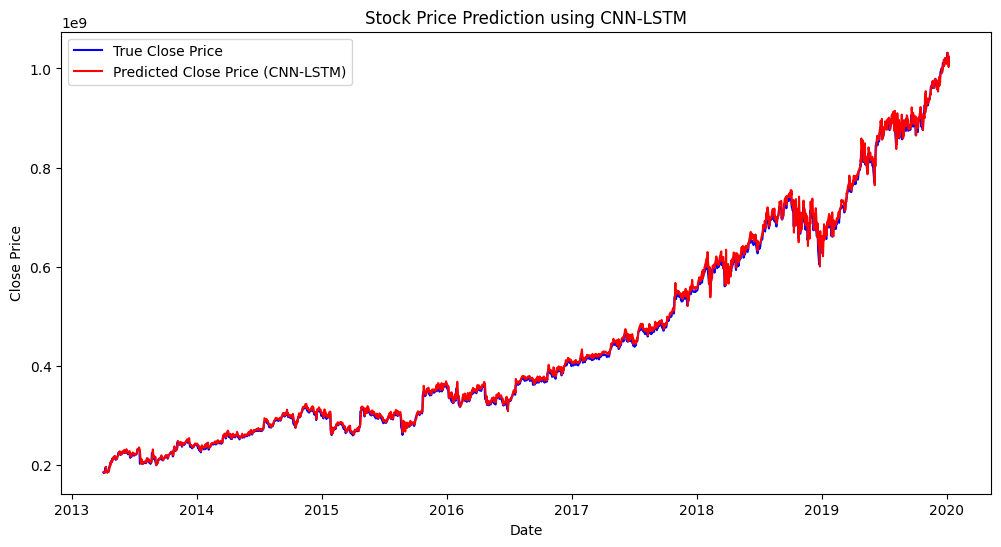

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_close, label='True Close Price', color='blue')
plt.plot(data.index[-len(y_test):], y_pred_close_cnn_lstm, label='Predicted Close Price (CNN-LSTM)', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction using CNN-LSTM')
plt.legend()
plt.show()